In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import random
from tqdm import tqdm
import cv2 as cv
import PIL
from PIL import Image
!pip install plotly
import plotly.express as px
from IPython import display

import tensorflow as tf
from tensorflow import keras

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

2021-10-16 01:18:14.444130: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
base_dir = '/kaggle/input/cryptopunks/'
os.listdir(base_dir)

['txn_history-2021-10-07.jsonl', 'imgs']

In [3]:
data_dir = '../input/cryptopunks/txn_history-2021-10-07.jsonl'
image_dir = "../input/cryptopunks/imgs/imgs"
image_root = "../input/cryptopunks/imgs"

In [4]:
df = pd.read_json(base_dir + 'txn_history-2021-10-07.jsonl', lines=True)
df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


Sample 100 CryptoPunks


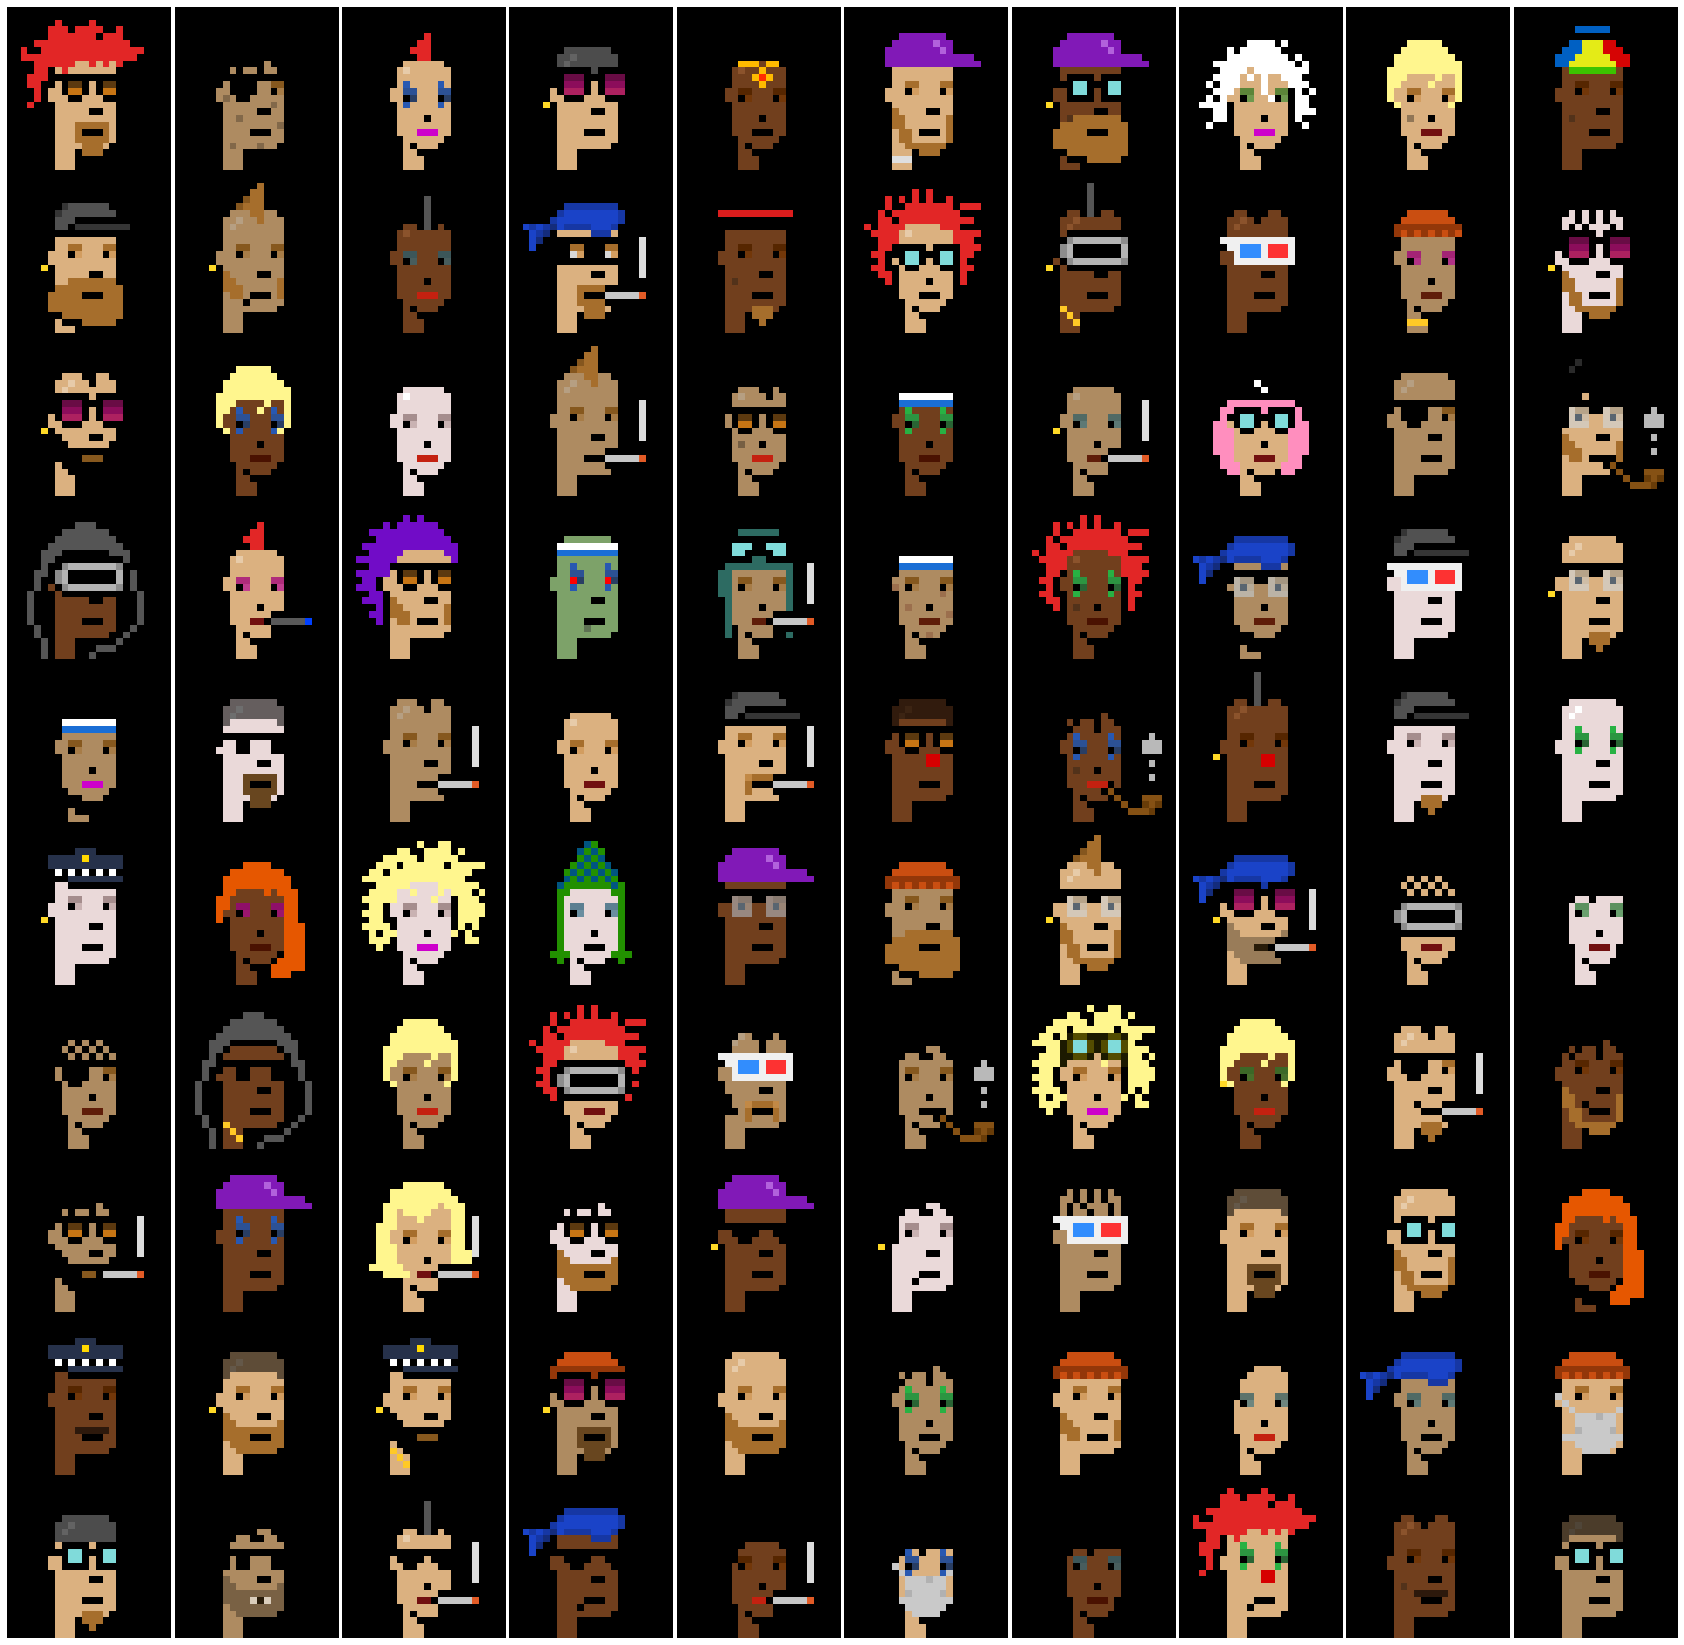

In [5]:
#look at 100 samples

#define number of rows and cols
no_plots = 10*10

#define path
images = glob.glob("../input/cryptopunks/imgs/imgs/*.png")

plt.rcParams['figure.figsize'] = (30, 30)
plt.subplots_adjust(wspace=0, hspace=0)

print("Sample 100 CryptoPunks")
for idx,image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    plt.subplot(10, 10, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB)) #covert color space
plt.show()

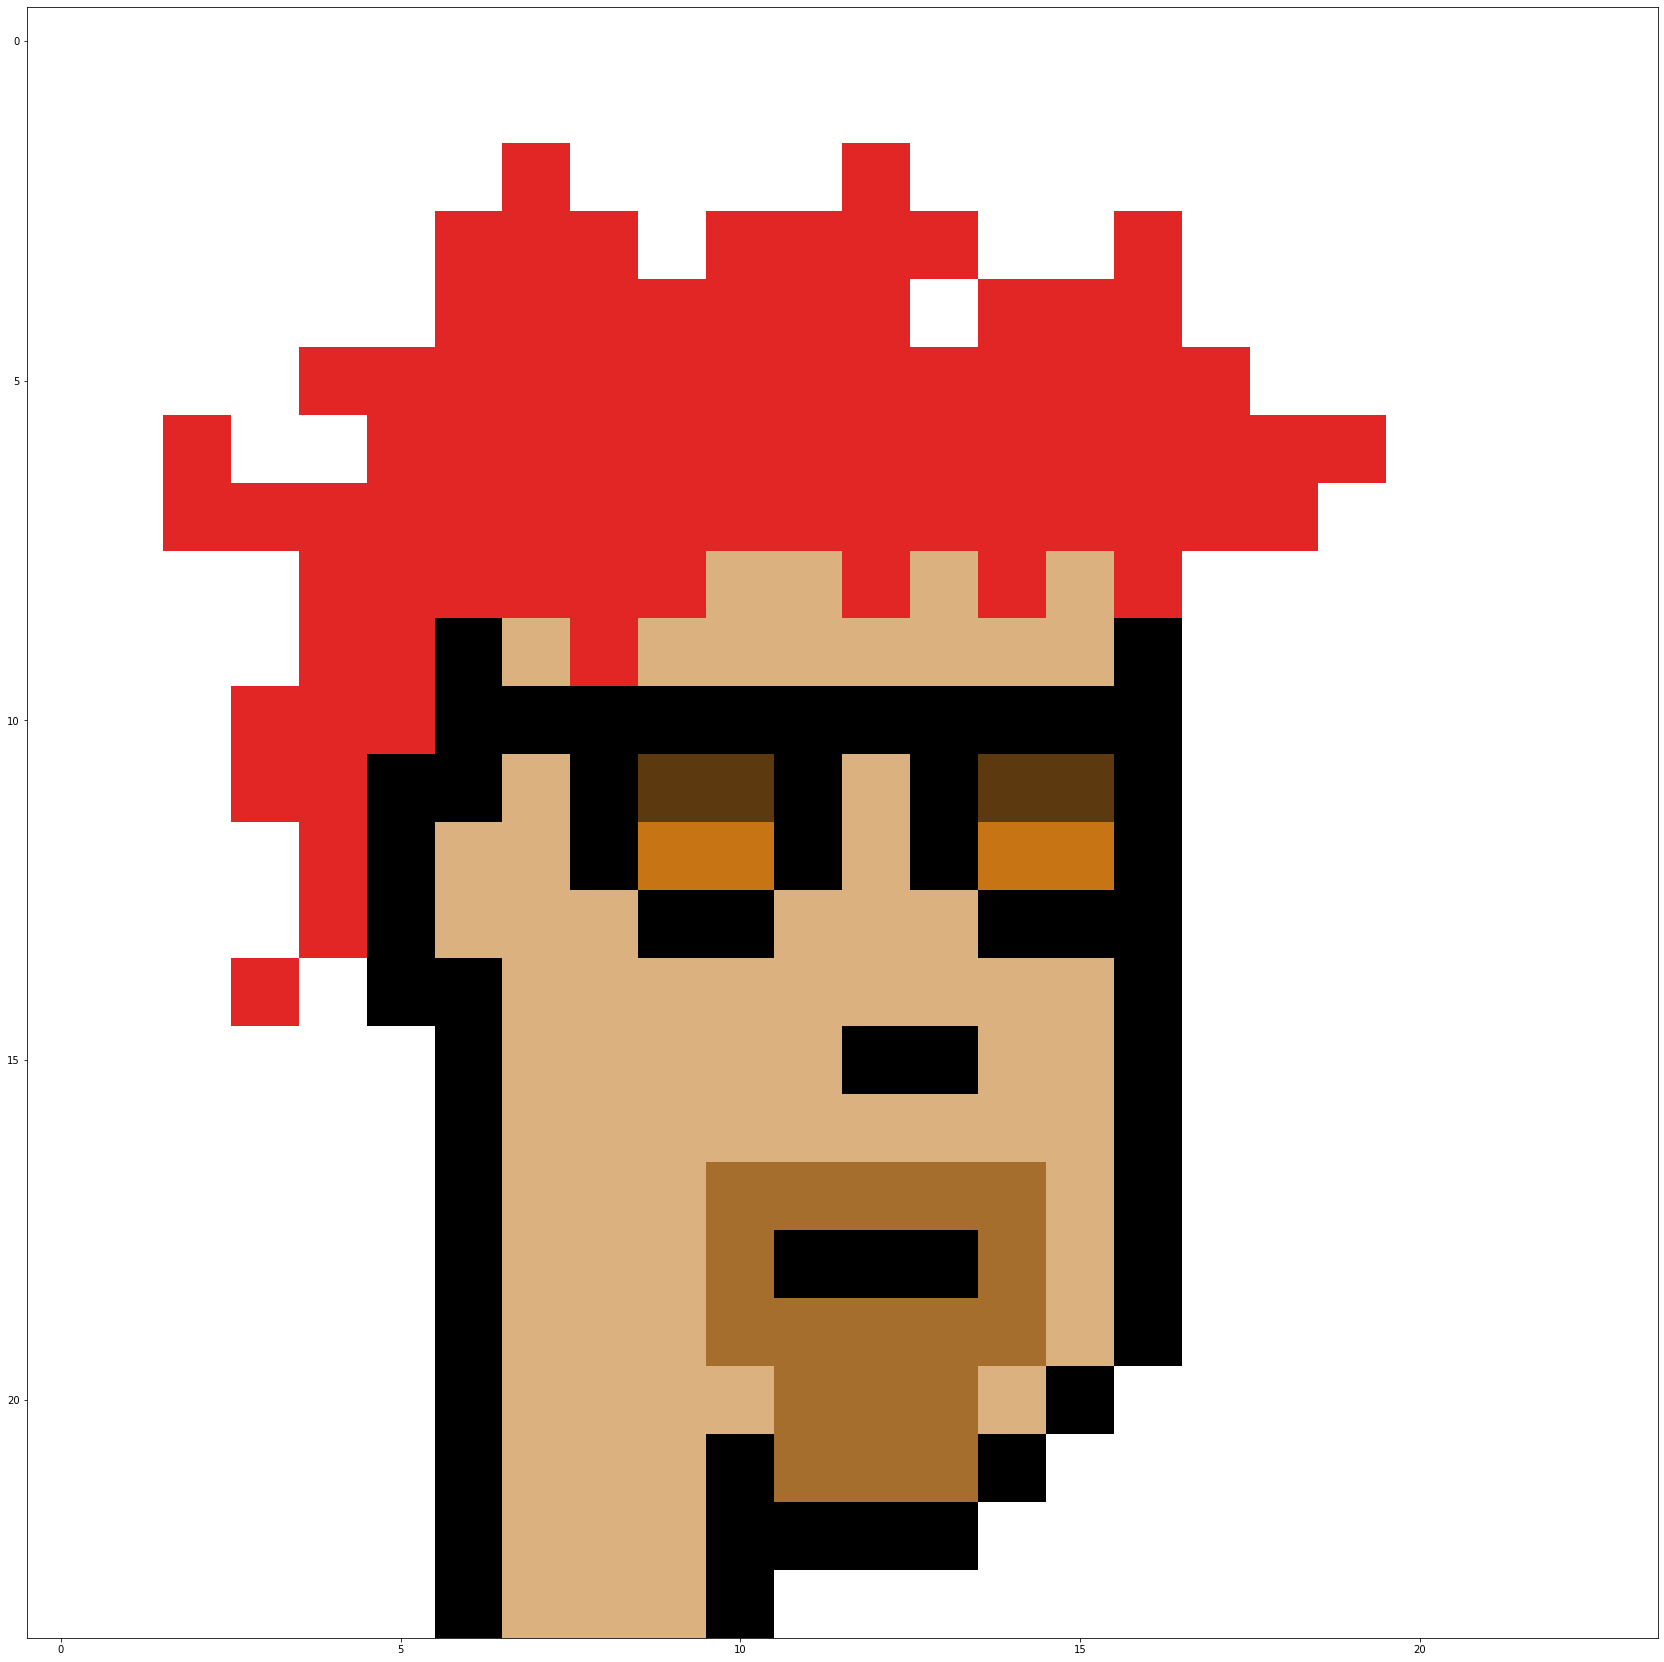

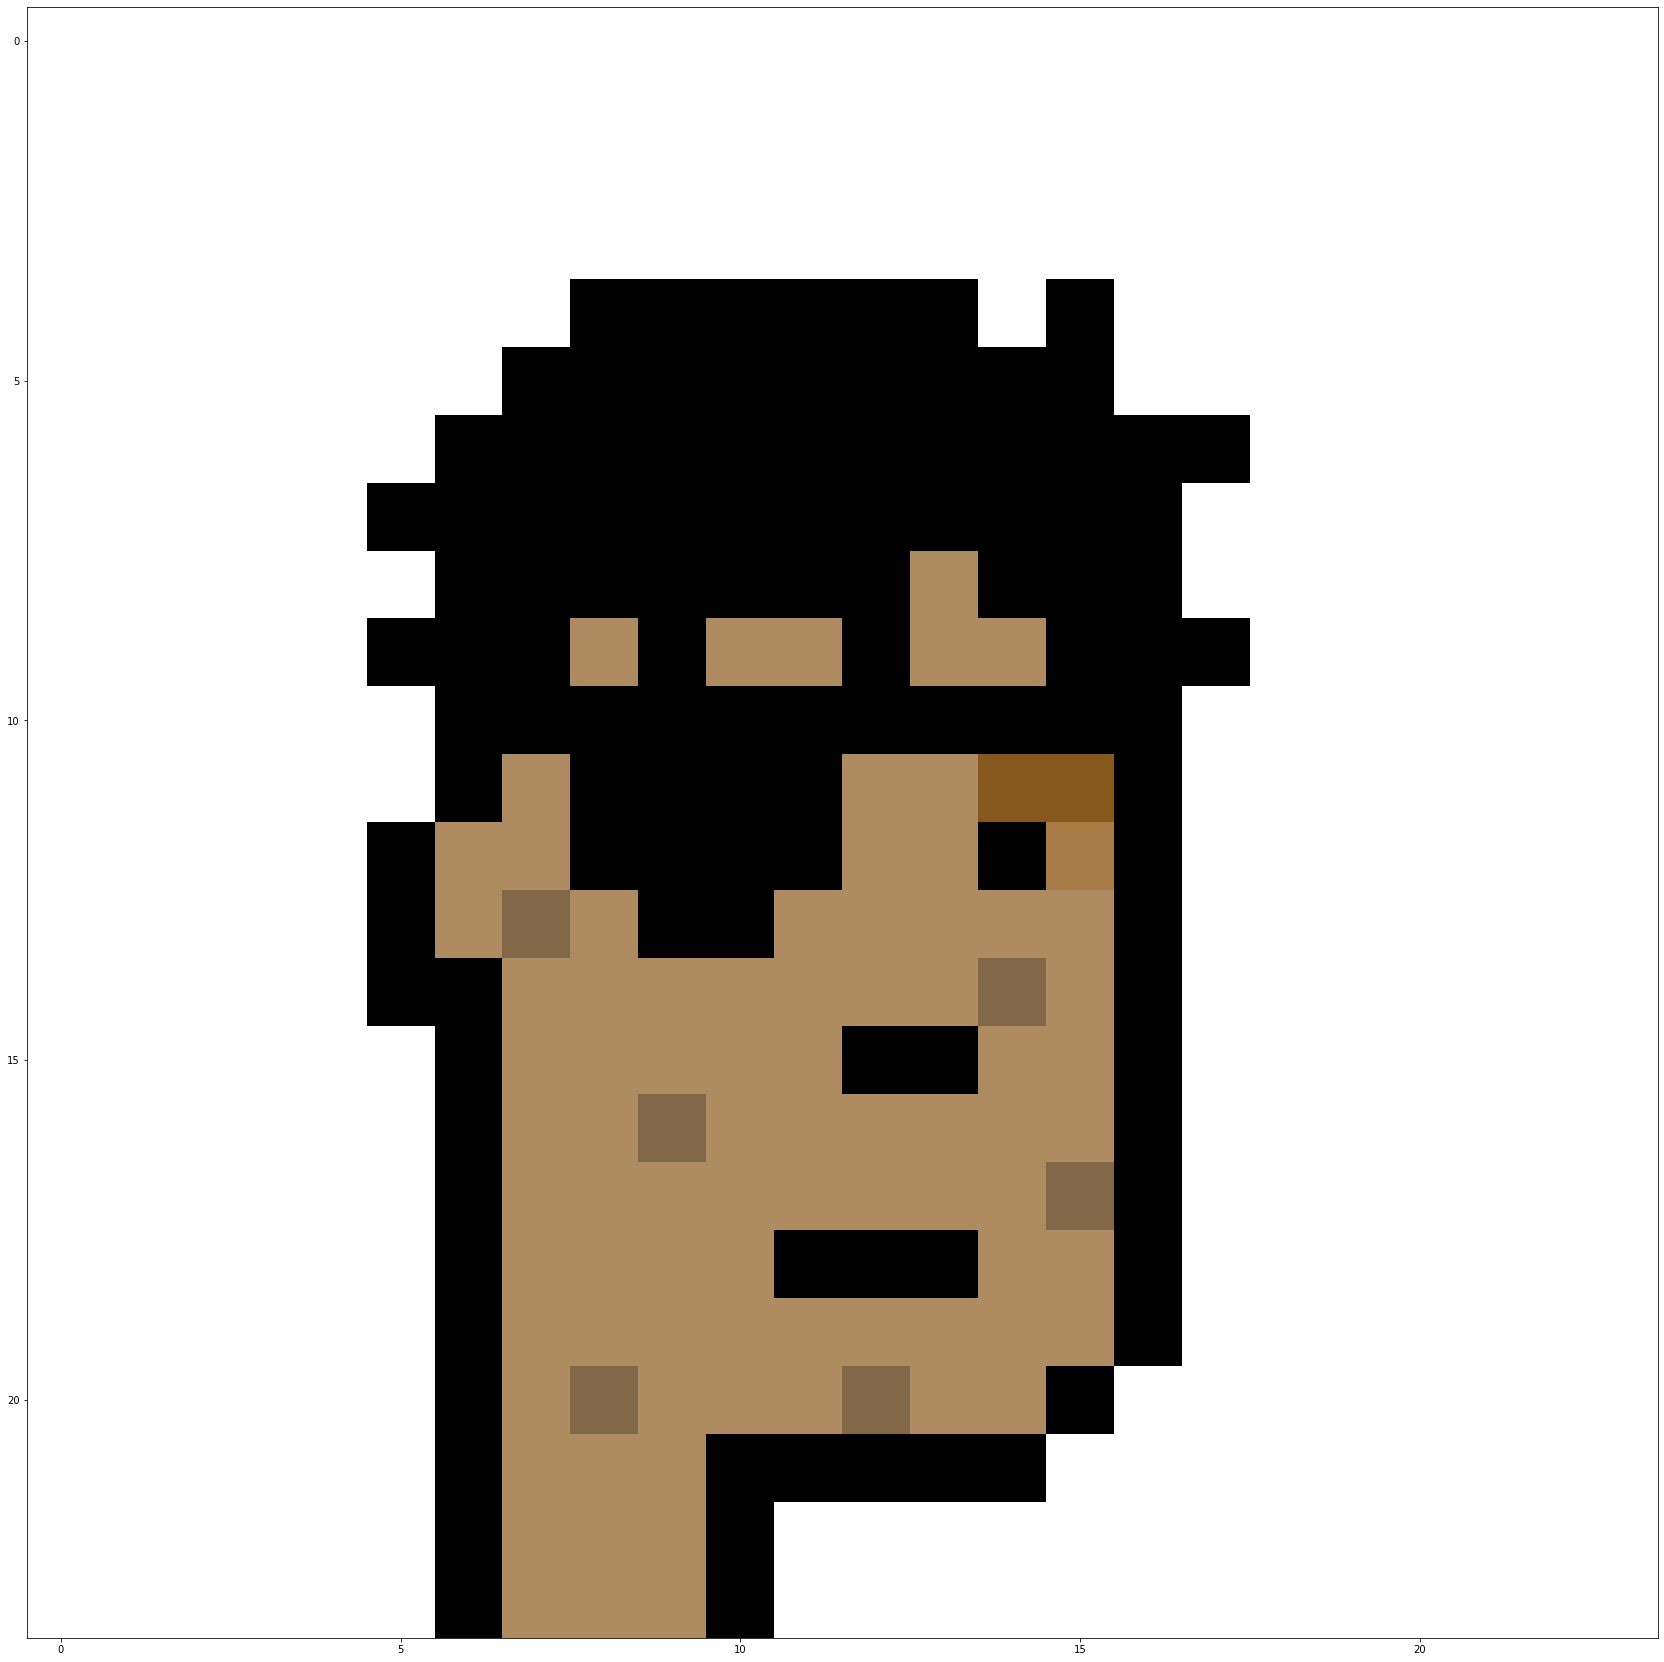

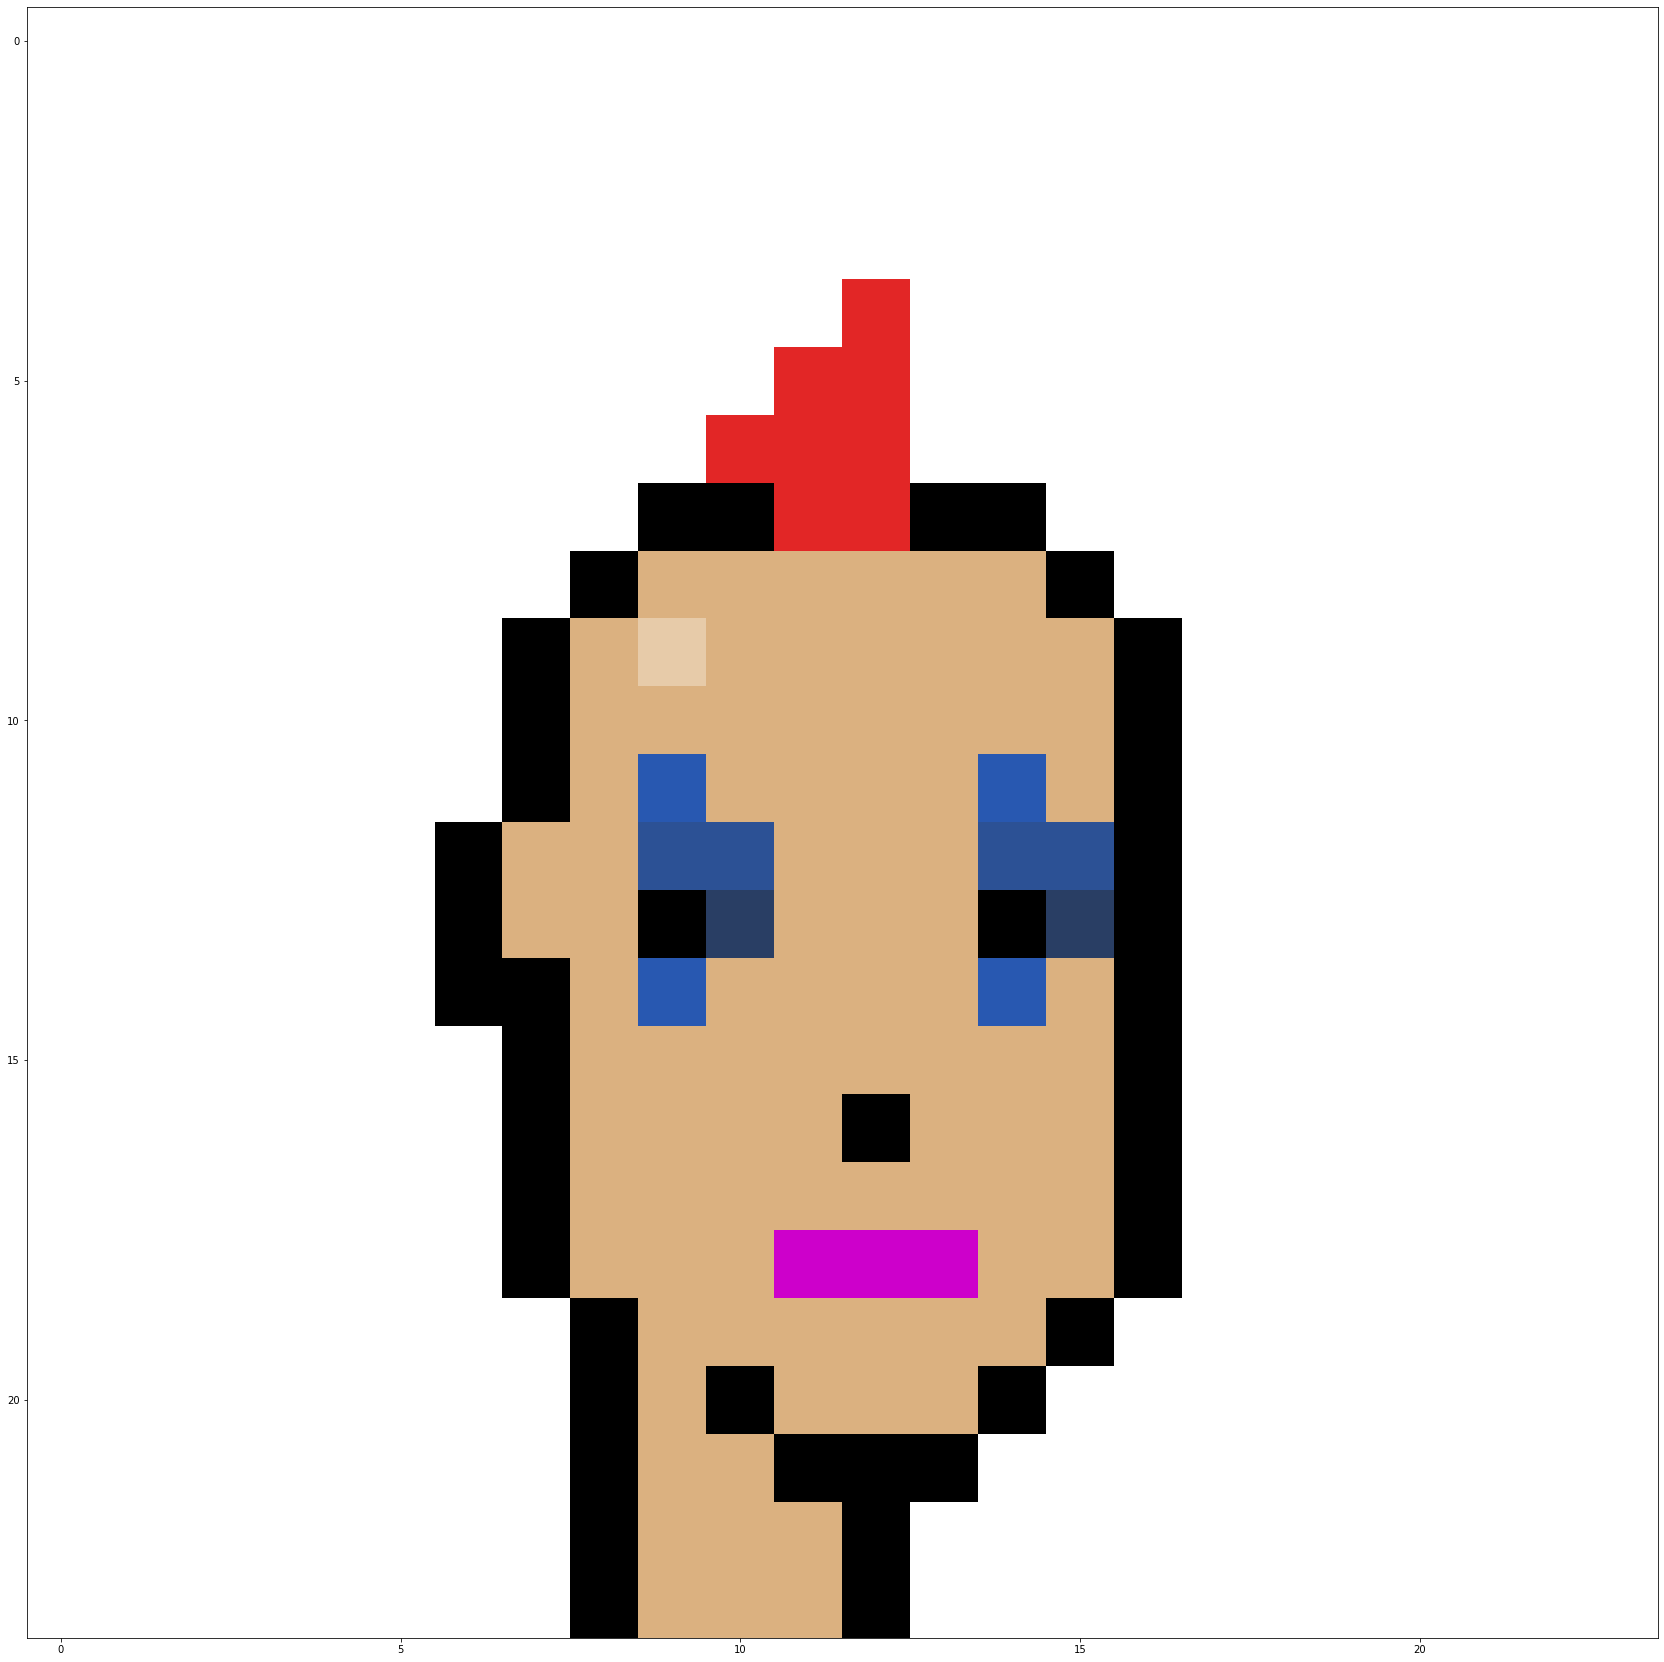

In [6]:
punks = [img for img in glob.glob("../input/cryptopunks/imgs/imgs/*.png")]

for punk in punks[0:3]:
    img = plt.imread(punk)
    plt.imshow(img)
    plt.show()

In [7]:
#check data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167492 entries, 0 to 167491
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   txn_type             167492 non-null  object        
 1   from                 167492 non-null  object        
 2   to                   167492 non-null  object        
 3   date                 167492 non-null  datetime64[ns]
 4   timestamp            167492 non-null  datetime64[ns]
 5   source               167492 non-null  object        
 6   eth                  127542 non-null  float64       
 7   punk_id              167492 non-null  int64         
 8   from_wallet_address  419 non-null     object        
 9   to_wallet_address    419 non-null     object        
 10  type                 167492 non-null  object        
 11  accessories          167492 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 15.3

In [8]:
#create new dataframe with only useful columns
df = df[["txn_type", "date", "eth", "punk_id", "type", "accessories"]]
df.head()

,txn_type,date,eth,punk_id,type,accessories
0,Bid Withdrawn,2021-09-04,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,2021-09-01,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,2021-09-01,263.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [9]:
#check statistics
df.describe()

,eth,punk_id
count,1.275420e+05,167492.000000
mean,7.071151e+08,5321.071932
std,2.520092e+11,2776.407382
min,0.000000e+00,0.000000
25%,2.250000e+00,2982.000000
50%,2.199000e+01,5400.000000
75%,5.300000e+01,7700.000000
max,9.000000e+13,9999.000000


In [10]:
#check for null values
df.isnull().sum()

txn_type           0
date               0
eth            39950
punk_id            0
type               0
accessories        0
dtype: int64

In [11]:
#value counts
df['txn_type'].value_counts()

Offered            65467
Bid                26808
Sold               18979
Bid Withdrawn      16342
Transfer           14225
Offer Withdrawn    10372
Claimed            10000
(Wrap)              2773
(Unwrap)            2526
Name: txn_type, dtype: int64

In [12]:
#value counts
df['type'].explode().value_counts()

Male      104154
Female     59873
Zombie      2251
Ape          787
Alien        427
Name: type, dtype: int64

In [13]:
#value counts
df['accessories'].explode().value_counts()

Earring           42717
Cigarette         15708
Mole              12311
Hot Lipstick      10517
Black Lipstick    10461
                  ...  
Beanie             1438
Orange Side        1346
Tiara              1300
Pilot Helmet       1277
Choker             1017
Name: accessories, Length: 87, dtype: int64

In [14]:
#price statistics
df['eth'].describe()

count    1.275420e+05
mean     7.071151e+08
std      2.520092e+11
min      0.000000e+00
25%      2.250000e+00
50%      2.199000e+01
75%      5.300000e+01
max      9.000000e+13
Name: eth, dtype: float64

In [15]:
#exploded 'type' list to rows of the subset columns
df = df.explode("type")
df.head()

,txn_type,date,eth,punk_id,type,accessories
0,Bid Withdrawn,2021-09-04,321.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,2021-09-01,321.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,2021-09-01,320.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,2021-09-01,320.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,2021-09-01,263.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"


In [16]:
#visualize
fig = px.bar(df[df.txn_type == 'Sold'].groupby("type").agg({"eth": "max"}).sort_values(by="eth").reset_index('type'),
             x="type", y="eth", 
             color="type", 
             title="CryptoPunk Type vs. Price")
fig.show()

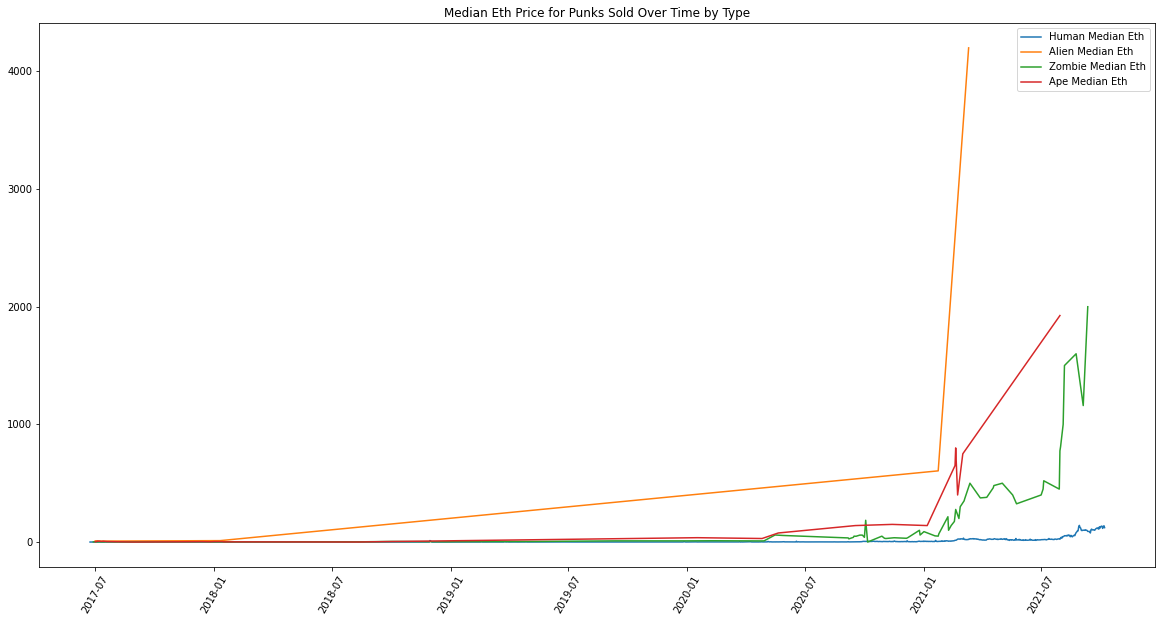

In [17]:
#visualize human
human = df[(df.txn_type == 'Sold') & ((df.type == "Female") | (df.type == "Male")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")

#visualize alien
alien = df[(df.txn_type == 'Sold') & ((df.type == "Alien")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")

#visualize zombie
zombie = df[(df.txn_type == 'Sold') & ((df.type == "Zombie")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")

#visualize ape
ape = df[(df.txn_type == 'Sold') & ((df.type == "Ape")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")

plt.figure(figsize=(20,10))
plt.plot(human['date'], human['eth']['median'], label="Human Median Eth")
plt.plot(alien['date'], alien['eth']['median'], label="Alien Median Eth")
plt.plot(zombie['date'], zombie['eth']['median'], label="Zombie Median Eth")
plt.plot(ape['date'], ape['eth']['median'], label="Ape Median Eth")
plt.legend()
plt.xticks(rotation=60)
plt.title("Median Eth Price for Punks Sold Over Time by Type")
plt.show()

In [18]:
#get number of attributes
df['num_attributes'] = df.accessories.apply(lambda x: len(x))

In [19]:
#compare number of attributes vs. price
fig = px.bar(df[(df.txn_type == "Sold") & ((df.type == "Female") | (df.type == "Male"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", y="eth", color="eth", title="Cryptopunk Price per Number of Attributes of Human Punks")
fig.show()

In [20]:
#visualize number of attributes vs price for alien
fig = px.bar(df[(df.txn_type == "Sold") & ((df.type == "Alien"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", y="eth", color="eth", title="Cryptopunk Price per Number of Attributes of Alien Punks")
fig.show()

In [21]:
#visualize number of attributes vs price for zombie
fig = px.bar(df[(df.txn_type == "Sold") & ((df.type == "Zombie"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", y="eth", color="eth", title="Cryptopunk Price per Number of Attributes of Zombie Punks")
fig.show()

In [22]:
#visualize number of attributes vs price for ape
fig = px.bar(df[(df.txn_type == "Sold") & ((df.type == "Ape"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", y="eth", color="eth", title="Cryptopunk Price per Number of Attributes of Ape Punks")
fig.show()

# DataLoader & Preprocessing

In [23]:
#helper display function
def tensor_imshow(img,dnorm=True):
    img = img.to('cpu')
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg*0.5+0.5
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [24]:
def get_dataloader(batch_size,image_size,data_dir=image_dir,num_workers=3):
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    transform = transforms.Compose([transforms.Resize((image_size,image_size)),
                                    transforms.ToTensor(),
                                    #tranform our image values to be between -1 and 1 (the range of the tanh activation)
                                    transforms.Normalize(*stats)])
    
    dataset = datasets.ImageFolder(root=data_dir,transform=transform)
    
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers,
                                              pin_memory=True)
    
    return data_loader

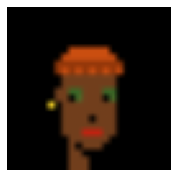

In [25]:
#test dataloader
batch_size, image_size = 5, 64
train_loader = get_dataloader(batch_size,image_size,image_root)
dataiter = iter(train_loader)

img,_ = next(dataiter)
sample_img = img[-1]
tensor_imshow(sample_img)

# Build Generator

In [26]:
class Generator(nn.Module):
    def __init__(self,z_dim=10,in_chan=3,hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.in_chan = in_chan
        self.hidden_dim = hidden_dim
        
        self.generator = nn.Sequential(
            self.make_gen_block(z_dim,512,stride=1,padding=0,),
            self.make_gen_block(512,256),
            self.make_gen_block(256,128),
            self.make_gen_block(128,64),
            self.make_gen_block(64,32),
            self.make_gen_block(32, in_chan,final_layer=True))
    
    def make_gen_block(self,in_channels,op_channels,kernel_size=4,stride=2,padding=1,final_layer=False):
        layers = []
        layers.append(nn.ConvTranspose2d(in_channels,op_channels,kernel_size,stride,padding,bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_channels))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())
        
        return nn.Sequential(*layers)
    
    def forward(self,noise):
        x = noise.view(-1,self.z_dim,1,1)
        return self.generator(x)

    def get_noise(n_samples, z_dim, device='cpu'):
        return torch.randn(n_samples, z_dim, device=device)

In [27]:
#test Generator
noise = Generator.get_noise(n_samples=5,z_dim=10)
g = Generator(z_dim=10,in_chan=3,hidden_dim=64)

#print(g)
img = g(noise)
print(img.shape)
assert img.shape == (5,3,128,128), "Generator Output Images shape incorrect"
print("Generator Test passed!!")

torch.Size([5, 3, 128, 128])
Generator Test passed!!


# Build Discriminator

In [28]:
class Discriminator(nn.Module):
    def __init__(self,im_chan=3,conv_dim=64,image_size=64):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        
        self.disc_cnn = nn.Sequential(
            self.make_disc_block(3,32),
            self.make_disc_block(32,64),
            self.make_disc_block(64,128),
            self.make_disc_block(128,256),
            self.make_disc_block(256,512),
            self.make_disc_block(512,1,padding=0,final_layer=True))
        
        
    def make_disc_block(self,in_chan,op_chan,kernel_size=4,stride=2,padding=1,final_layer=False):
        layers = []
        layers.append(nn.Conv2d(in_chan,op_chan,kernel_size,stride,padding,bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return nn.Sequential(*layers)
    
    
    def forward(self,image):
        pred = self.disc_cnn(image)
        pred = pred.view(image.size(0),-1)
        return pred
    
    def _get_final_feature_dimention(self):
        final_width_height = (self.image_size //  2**len(self.disc_cnn))**2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [29]:
#test Discriminator
d = Discriminator(im_chan=3,conv_dim=128,image_size=64)

#print(d)
img = torch.rand(4,3,128,128)
d_op = d(img)
assert d_op.shape == (4,1),"Discriminator Output Images shape incorrect"
print("Discriminator test passed!!")

Discriminator test passed!!


# Define Training Parameters

In [30]:
def weights_init_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [31]:
def real_loss(D_out,device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size,device=device)*0.9 #real labels = 1 and lable smoothing => 0.9
    
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [32]:
def fake_loss(D_out,device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size,device=device) #fake labels = 0
    
    loss = criterion(D_out.squeeze(),labels)
    return loss

# Train 

In [33]:
def print_tensor_images(images_tensor):
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx,image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        #dnorm
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
        
    plt.show()

In [34]:
def train(D, G, n_epochs,dataloader,d_optimizer,g_optimizer,z_dim,print_every=50,device='cpu'):
    
    #get some fixed data for sampling#      
    sample_size=8
    fixed_z = Generator.get_noise(n_samples=sample_size,z_dim=z_dim,device=device)
    
    for epoch in range(1,n_epochs+1):
        for batch_i,(real_images,_) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            ### Discriminator part ###
            d_optimizer.zero_grad()
            
            #loss on real image
            d_real_op = D(real_images)
            d_real_loss = real_loss(d_real_op,device=device)
            
            #loss on fake image
            noise = Generator.get_noise(n_samples=batch_size,z_dim=z_dim,device=device)
            fake_images = G(noise)
            d_fake_op = D(fake_images)
            d_fake_loss = fake_loss(d_fake_op,device=device)
            
            #total loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            ### Generator part ###
            g_optimizer.zero_grad()
            noise = Generator.get_noise(n_samples=batch_size,z_dim=z_dim,device=device)
            g_out = G(noise)
            d_out = D(g_out)
            
            g_loss = real_loss(d_out,device=device)
            g_loss.backward()
            g_optimizer.step()
        
        
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_loss.item(), g_loss.item()))
        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z)
            print_tensor_images(sample_image)
            G.train()

In [35]:
# heperparams
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ",device)

z_dim = 150
beta_1 = 0.5
beta_2 = 0.999 

n_epochs = 150
lr = 0.0002

batch_size = 128
image_size = 128

Device is  cuda


In [36]:
#model init
generator = Generator(z_dim,in_chan=3,hidden_dim=64).to(device)
discriminator = Discriminator(im_chan=3,conv_dim=64,image_size=image_size).to(device)


#optimizer init
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

dataloader = get_dataloader(batch_size,image_size,image_root)

Epoch [    1/  100] | d_loss: 0.6623 | g_loss: 14.8426
Epoch [    2/  100] | d_loss: 0.3578 | g_loss: 6.0462
Epoch [    3/  100] | d_loss: 0.3326 | g_loss: 10.0716
Epoch [    4/  100] | d_loss: 0.6831 | g_loss: 0.4561
Epoch [    5/  100] | d_loss: 0.4089 | g_loss: 6.4831
Epoch [    6/  100] | d_loss: 0.3899 | g_loss: 3.7797
Epoch [    7/  100] | d_loss: 0.5995 | g_loss: 2.2206
Epoch [    8/  100] | d_loss: 0.4417 | g_loss: 3.3657
Epoch [    9/  100] | d_loss: 1.8875 | g_loss: 11.3888
Epoch [   10/  100] | d_loss: 0.4591 | g_loss: 3.1678


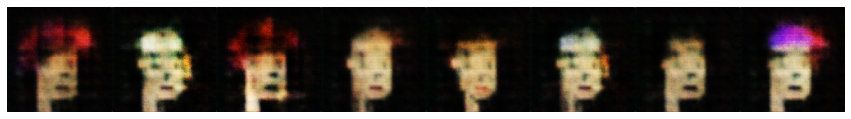

Epoch [   11/  100] | d_loss: 0.5054 | g_loss: 4.8115
Epoch [   12/  100] | d_loss: 0.3693 | g_loss: 5.4083
Epoch [   13/  100] | d_loss: 0.3758 | g_loss: 2.8871
Epoch [   14/  100] | d_loss: 0.5019 | g_loss: 5.5990
Epoch [   15/  100] | d_loss: 0.3958 | g_loss: 4.8449
Epoch [   16/  100] | d_loss: 0.3593 | g_loss: 4.3325
Epoch [   17/  100] | d_loss: 0.5938 | g_loss: 2.3014
Epoch [   18/  100] | d_loss: 0.4274 | g_loss: 3.0726
Epoch [   19/  100] | d_loss: 0.3682 | g_loss: 4.3873
Epoch [   20/  100] | d_loss: 1.5712 | g_loss: 2.0684


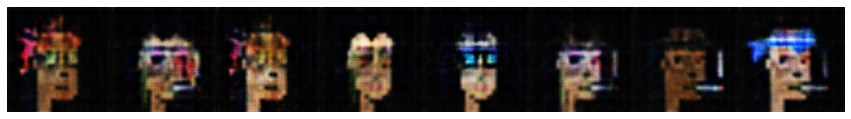

Epoch [   21/  100] | d_loss: 0.4015 | g_loss: 3.5416
Epoch [   22/  100] | d_loss: 0.4075 | g_loss: 2.8050
Epoch [   23/  100] | d_loss: 0.3515 | g_loss: 4.4220
Epoch [   24/  100] | d_loss: 0.3958 | g_loss: 2.2509
Epoch [   25/  100] | d_loss: 0.5943 | g_loss: 3.2503
Epoch [   26/  100] | d_loss: 1.8005 | g_loss: 0.6129
Epoch [   27/  100] | d_loss: 0.3851 | g_loss: 2.6292
Epoch [   28/  100] | d_loss: 0.3864 | g_loss: 3.5217
Epoch [   29/  100] | d_loss: 0.4298 | g_loss: 2.6326
Epoch [   30/  100] | d_loss: 0.4394 | g_loss: 5.8227


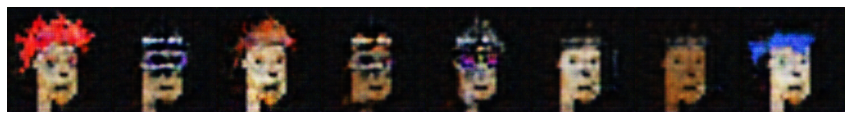

Epoch [   31/  100] | d_loss: 0.5710 | g_loss: 4.9933
Epoch [   32/  100] | d_loss: 0.9370 | g_loss: 1.6190
Epoch [   33/  100] | d_loss: 0.3604 | g_loss: 4.9937
Epoch [   34/  100] | d_loss: 1.8539 | g_loss: 0.4655
Epoch [   35/  100] | d_loss: 0.3835 | g_loss: 4.0423
Epoch [   36/  100] | d_loss: 1.0337 | g_loss: 0.7937
Epoch [   37/  100] | d_loss: 0.7171 | g_loss: 0.6266
Epoch [   38/  100] | d_loss: 0.5569 | g_loss: 2.2905
Epoch [   39/  100] | d_loss: 0.3632 | g_loss: 4.5849
Epoch [   40/  100] | d_loss: 0.3720 | g_loss: 2.6844


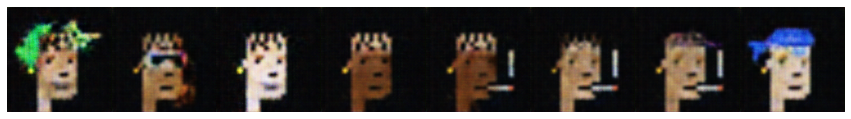

Epoch [   41/  100] | d_loss: 0.3480 | g_loss: 5.2862
Epoch [   42/  100] | d_loss: 0.8165 | g_loss: 1.5598
Epoch [   43/  100] | d_loss: 0.5753 | g_loss: 1.7249
Epoch [   44/  100] | d_loss: 0.4456 | g_loss: 1.7872
Epoch [   45/  100] | d_loss: 0.5972 | g_loss: 1.6841
Epoch [   46/  100] | d_loss: 0.4013 | g_loss: 4.2235
Epoch [   47/  100] | d_loss: 0.3358 | g_loss: 6.2744
Epoch [   48/  100] | d_loss: 0.6256 | g_loss: 1.7900
Epoch [   49/  100] | d_loss: 0.3586 | g_loss: 4.8029
Epoch [   50/  100] | d_loss: 0.3485 | g_loss: 6.6811


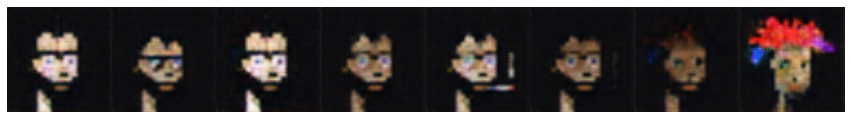

Epoch [   51/  100] | d_loss: 0.6317 | g_loss: 2.3240
Epoch [   52/  100] | d_loss: 0.3607 | g_loss: 4.4286
Epoch [   53/  100] | d_loss: 0.4099 | g_loss: 3.3567
Epoch [   54/  100] | d_loss: 2.0177 | g_loss: 0.5026
Epoch [   55/  100] | d_loss: 0.3833 | g_loss: 5.0493
Epoch [   56/  100] | d_loss: 1.0904 | g_loss: 0.7882
Epoch [   57/  100] | d_loss: 0.8634 | g_loss: 1.0305
Epoch [   58/  100] | d_loss: 0.5061 | g_loss: 2.7973
Epoch [   59/  100] | d_loss: 0.3441 | g_loss: 5.5982
Epoch [   60/  100] | d_loss: 0.5593 | g_loss: 4.5575


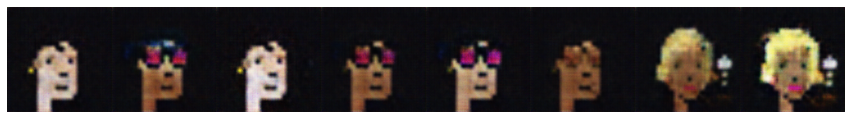

Epoch [   61/  100] | d_loss: 0.4375 | g_loss: 2.6800
Epoch [   62/  100] | d_loss: 0.4450 | g_loss: 2.5840
Epoch [   63/  100] | d_loss: 1.0879 | g_loss: 0.4236
Epoch [   64/  100] | d_loss: 0.3414 | g_loss: 5.4268
Epoch [   65/  100] | d_loss: 0.3474 | g_loss: 3.8403
Epoch [   66/  100] | d_loss: 0.3702 | g_loss: 4.3978
Epoch [   67/  100] | d_loss: 0.4180 | g_loss: 5.5640
Epoch [   68/  100] | d_loss: 0.4497 | g_loss: 4.2537
Epoch [   69/  100] | d_loss: 1.2011 | g_loss: 1.2528
Epoch [   70/  100] | d_loss: 0.4057 | g_loss: 3.2094


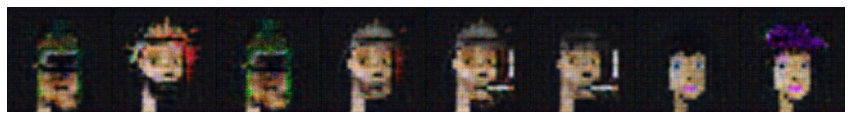

Epoch [   71/  100] | d_loss: 0.3674 | g_loss: 3.3713
Epoch [   72/  100] | d_loss: 0.5546 | g_loss: 2.1293
Epoch [   73/  100] | d_loss: 0.3627 | g_loss: 4.3807
Epoch [   74/  100] | d_loss: 0.6844 | g_loss: 1.5540
Epoch [   75/  100] | d_loss: 0.3359 | g_loss: 4.9609
Epoch [   76/  100] | d_loss: 0.3488 | g_loss: 4.2328
Epoch [   77/  100] | d_loss: 0.3855 | g_loss: 5.3698
Epoch [   78/  100] | d_loss: 0.3573 | g_loss: 6.5548
Epoch [   79/  100] | d_loss: 0.6703 | g_loss: 4.5805
Epoch [   80/  100] | d_loss: 0.6048 | g_loss: 1.4845


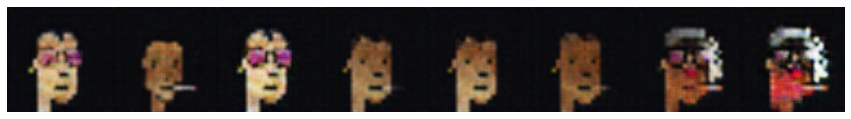

Epoch [   81/  100] | d_loss: 0.9383 | g_loss: 1.0587
Epoch [   82/  100] | d_loss: 0.5687 | g_loss: 1.1434
Epoch [   83/  100] | d_loss: 0.4821 | g_loss: 3.0273
Epoch [   84/  100] | d_loss: 0.5030 | g_loss: 2.7470
Epoch [   85/  100] | d_loss: 0.5264 | g_loss: 3.2424
Epoch [   86/  100] | d_loss: 0.4927 | g_loss: 3.4735
Epoch [   87/  100] | d_loss: 0.5170 | g_loss: 2.9842
Epoch [   88/  100] | d_loss: 0.3587 | g_loss: 4.8653
Epoch [   89/  100] | d_loss: 1.6686 | g_loss: 1.6415
Epoch [   90/  100] | d_loss: 0.3522 | g_loss: 6.6205


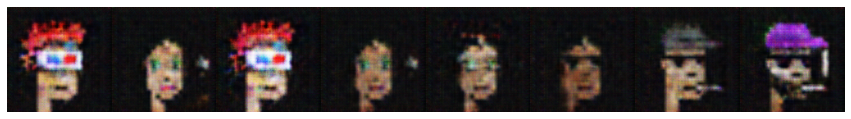

Epoch [   91/  100] | d_loss: 0.5536 | g_loss: 2.2171
Epoch [   92/  100] | d_loss: 0.3531 | g_loss: 5.4035
Epoch [   93/  100] | d_loss: 0.3514 | g_loss: 7.3899
Epoch [   94/  100] | d_loss: 0.6040 | g_loss: 3.2849
Epoch [   95/  100] | d_loss: 0.5829 | g_loss: 3.6233
Epoch [   96/  100] | d_loss: 0.3412 | g_loss: 7.0742
Epoch [   97/  100] | d_loss: 0.3372 | g_loss: 5.2668
Epoch [   98/  100] | d_loss: 0.4142 | g_loss: 4.8268
Epoch [   99/  100] | d_loss: 0.3346 | g_loss: 5.3427
Epoch [  100/  100] | d_loss: 0.4444 | g_loss: 5.1672


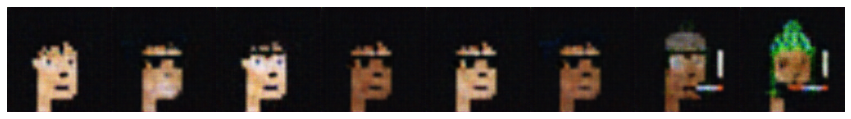

In [37]:
n_epochs = 100
train(discriminator,
      generator,
      n_epochs,
      dataloader,
      d_optimizer,
      g_optimizer,
      z_dim,
      print_every=10,
      device=device)

In [38]:
def save_model(generator,file_name):
    generator = generator.to('cuda')
    torch.save(generator.state_dict(),"cryptopunks_generator.pth")

save_model(generator,"kaggle")

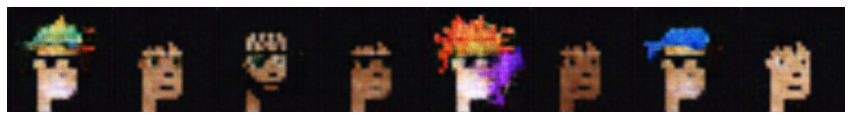

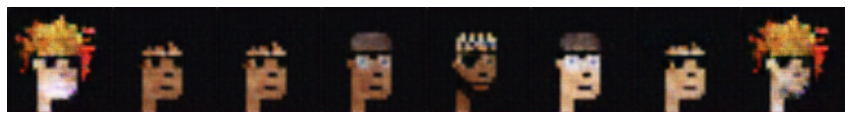

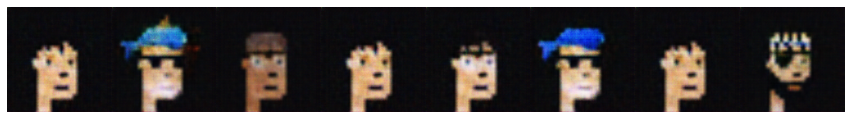

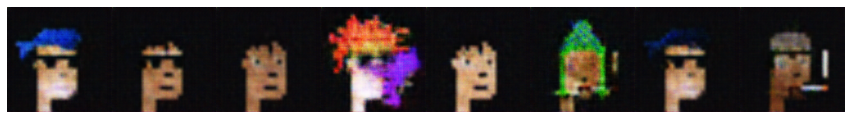

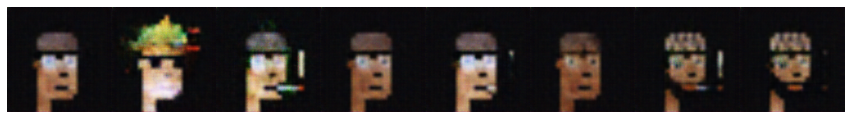

In [39]:
#sample generation
generator.to(device)
generator.eval()
sample_size=8
for i in range(5):
    fixed_z = Generator.get_noise(n_samples=sample_size,z_dim=z_dim,device=device)    
    sample_image = generator(fixed_z)
    print_tensor_images(sample_image)

# Create GIF

In [40]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()